# 0.preparatory
* (I). Importing packages, enabling gpu and setting tensorflow version

In [1]:
# %tensorflow_version 2.x

In [2]:
from tensorflow import random
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
import tensorflow as tf
import math
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# set random seed
np.random.seed(10086)
random.set_seed(10010)

# 1.PM2.5 prediction by environmental factors
* (I). Loading data

In [3]:
raw_df = pd.read_csv("./data/PRSA_Data_Huairou_20130301-20170228.csv")

raw_dfs = []
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Aotizhongxin_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Changping_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Dingling_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Dongsi_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Guanyuan_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Huairou_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Nongzhanguan_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Shunyi_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Tiantan_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Wanliu_20130301-20170228.csv"))
raw_dfs.append(pd.read_csv("./data/PRSA_Data_Wanshouxigong_20130301-20170228.csv"))
station_info=[]
for item in raw_dfs:
    station_info.append(item["station"].values[0])
station_info

['Aotizhongxin',
 'Changping',
 'Dingling',
 'Dongsi',
 'Guanyuan',
 'Huairou',
 'Nongzhanguan',
 'Shunyi',
 'Tiantan',
 'Wanliu',
 'Wanshouxigong']

In [4]:
def RHcovert(templist,dewlist):
    rh=[]
    for temp,dew in zip(templist,dewlist):
        rh.append(math.exp(17.27*dew/(237.7+dew)-17.27*temp/(237.7+temp)))
    return rh

* (II). Data processing
* * (1). Transform functions

In [5]:
# label to id,not used
def label_fit_transform(data_frame, col_name):

    data_frame[col_name] = preprocessing.LabelEncoder().fit_transform(data_frame[col_name])
    return data_frame
# standardization, make data form min-max to 0-1
def standardization(data_frame):
    buffer = data_frame.copy()
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    standard_values = min_max_scaler.fit_transform(buffer)
    for i, col_name in enumerate(buffer.columns):
        buffer[col_name] = standard_values[:, i]

    return buffer
# This step is used for lookback
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    from pandas import DataFrame, concat

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.coumns[j], i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
def transform(values):
    return values.reshape(values.shape[0], 1, values.shape[1])

In [6]:
# predict ${predict_forward} hour after by look_back hours data
look_back = 0
predict_forward = 1

* (II). Data processing
* * (2). Normalization,splitting and dropping blank

In [7]:
# drop usless Columns
current_data=[]
for item in raw_dfs:
    current_data.append(item.copy())
train_x=[]
train_y=[]
valid_x=[]
valid_y=[]
test_x=[]
test_y=[]
split_pointlist=[]
info_data=0
origindatalist=[]
maxlist=[]
minlist=[]
for item in current_data:
    item.drop(["No","year","month","hour", "day","wd","station"], axis=1, inplace=True)
    item["RH"]=RHcovert(item["TEMP"],item["DEWP"])
    item.drop(["TEMP","DEWP"], axis=1, inplace=True)
    item.dropna()
    item=item.reset_index()
    max_value = np.max(item["PM2.5"])
    min_value = np.min(item["PM2.5"])
    maxlist.append(max_value)
    minlist.append(min_value)
    
    item=series_to_supervised(
        standardization(item), look_back, predict_forward).drop(
        [
            "PRES(t)","index(t)"
         ], axis=1, inplace=False).astype('float32')
    item["PM2.5"]=item["PM2.5(t)"]
    item.drop(["PM2.5(t)"],axis=1,inplace=True)
    total=item.shape[0]    
    split_point = [total * 60 // 100, total * 80 // 100]
    split_pointlist.append(split_point)
    train_data = item[:split_point[0]].values
    valid_data = item[split_point[0]: split_point[1]].values
    test_data = item[split_point[1]: ].values
    train_x_temp, train_y_temp = transform(train_data[:, : -1]), train_data[:, -1]
    valid_x_temp, valid_y_temp = transform(valid_data[:, : -1]), valid_data[:, -1]
    test_x_temp, test_y_temp = transform(test_data[:, : -1]), test_data[:, -1]
    train_x.append(train_x_temp)
    train_y.append(train_y_temp)
    valid_x.append(valid_x_temp)
    valid_y.append(valid_y_temp)
    test_x.append(test_x_temp)
#     print(len(test_x_temp),split_point[1],len(item))
    test_y.append(test_y_temp)
    origindatalist.append(item)
    infodata=item

In [9]:
with open("./model/min_max_x.csv","w") as f:
    for item in current_data[0].columns.values:
        f.write(item+"min"+","+item+"max"+",")
    f.write("station")
    f.write("\n")
    for item,st in zip(current_data,station_info):
        for col in item:
            f.write(str(np.min(item[col]))+","+str(np.max(item[col]))+",")
        f.write(st)
        f.write("\n")

In [10]:
infodata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32829 entries, 0 to 35063
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PM10(t)  32829 non-null  float32
 1   SO2(t)   32829 non-null  float32
 2   NO2(t)   32829 non-null  float32
 3   CO(t)    32829 non-null  float32
 4   O3(t)    32829 non-null  float32
 5   RAIN(t)  32829 non-null  float32
 6   WSPM(t)  32829 non-null  float32
 7   RH(t)    32829 non-null  float32
 8   PM2.5    32829 non-null  float32
dtypes: float32(9)
memory usage: 1.4 MB


In [11]:
current_data[0].head()

,PM2.5,PM10,SO2,NO2,CO,O3,PRES,RAIN,WSPM,RH
0,4.0,4.0,4.0,7.0,300.0,77.0,1023.0,0.0,4.4,0.238781
1,8.0,8.0,4.0,7.0,300.0,77.0,1023.2,0.0,4.7,0.258810
2,7.0,7.0,5.0,10.0,300.0,73.0,1023.5,0.0,5.6,0.258810
3,6.0,6.0,11.0,11.0,300.0,72.0,1024.5,0.0,3.1,0.238726
4,3.0,3.0,12.0,12.0,300.0,72.0,1025.2,0.0,2.0,0.247379


* (III). Building models
* * (1). Setting layers and fitting models.

In [12]:
modellist=[]
for item in train_x:
    model = keras.Sequential()
    model.add(tf.keras.layers.Dense(32, input_shape=(item.shape[1], item.shape[2]),activation="tanh"))
    model.add(tf.keras.layers.Dense(input_shape=(None,64),units=32,activation="tanh"))
    model.add(tf.keras.layers.Dense(input_shape=(None,32),units=16,activation="relu"))
    model.add(tf.keras.layers.Dense(input_shape=(None,16),units=1024,activation="relu"))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss="mae", optimizer="Adamax")
    modellist.append(model)

In [13]:
modellist[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             288       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 32)             1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1, 16)             528       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1024)           17408     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1)              1025      
Total params: 20,305
Trainable params: 20,305
Non-trainable params: 0
_________________________________________________________________


In [14]:
# history = model.fit(train_x,
#                     train_y,
#                     validation_data=(valid_x, valid_y),
#                     epochs=10,
#                     batch_size=32,
#                     verbose=1,
#                     shuffle=True)
historylist=[]
for model,t_x,t_y,v_x,v_y in zip(modellist,train_x,train_y,valid_x,valid_y):
    historylist.append(model.fit(t_x,
                    t_y,
                    validation_data=(v_x, v_y),
                    epochs=32,
                    batch_size=1024,
                    verbose=1,
                    shuffle=True))

Train on 19125 samples, validate on 6375 samples
Epoch 1/32
19125/19125 [==============================] - 1s 46us/sample - loss: 0.0526 - val_loss: 0.0463
Epoch 2/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0369 - val_loss: 0.0303
Epoch 3/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0298 - val_loss: 0.0254
Epoch 4/32
19125/19125 [==============================] - 0s 4us/sample - loss: 0.0267 - val_loss: 0.0233
Epoch 5/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0245 - val_loss: 0.0210
Epoch 6/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0229 - val_loss: 0.0193
Epoch 7/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0217 - val_loss: 0.0183
Epoch 8/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0210 - val_loss: 0.0174
Epoch 9/32
19125/19125 [==============================] - 0s 3us/sample - loss: 0.0205 - val_loss: 0.0

* (III). Building models
* * (2) Visualization for training process

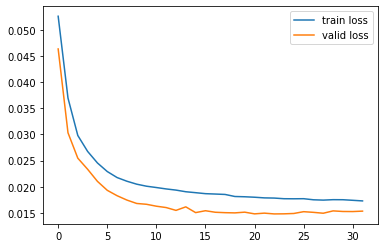

In [16]:
plt.plot(historylist[0].history["loss"], label="train loss")
plt.plot(historylist[0].history["val_loss"], label="valid loss")
plt.legend()
plt.show()

* (IV). Results of models

Aotizhongxin : [0.92700471]
Changping : [0.92740307]
Dingling : [0.95315934]
Dongsi : [0.9270339]
Guanyuan : [0.92486793]
Huairou : [0.91239816]
Nongzhanguan : [0.93422945]
Shunyi : [0.9321358]
Tiantan : [0.92514167]
Wanliu : [0.90692718]
Wanshouxigong : [0.92876979]


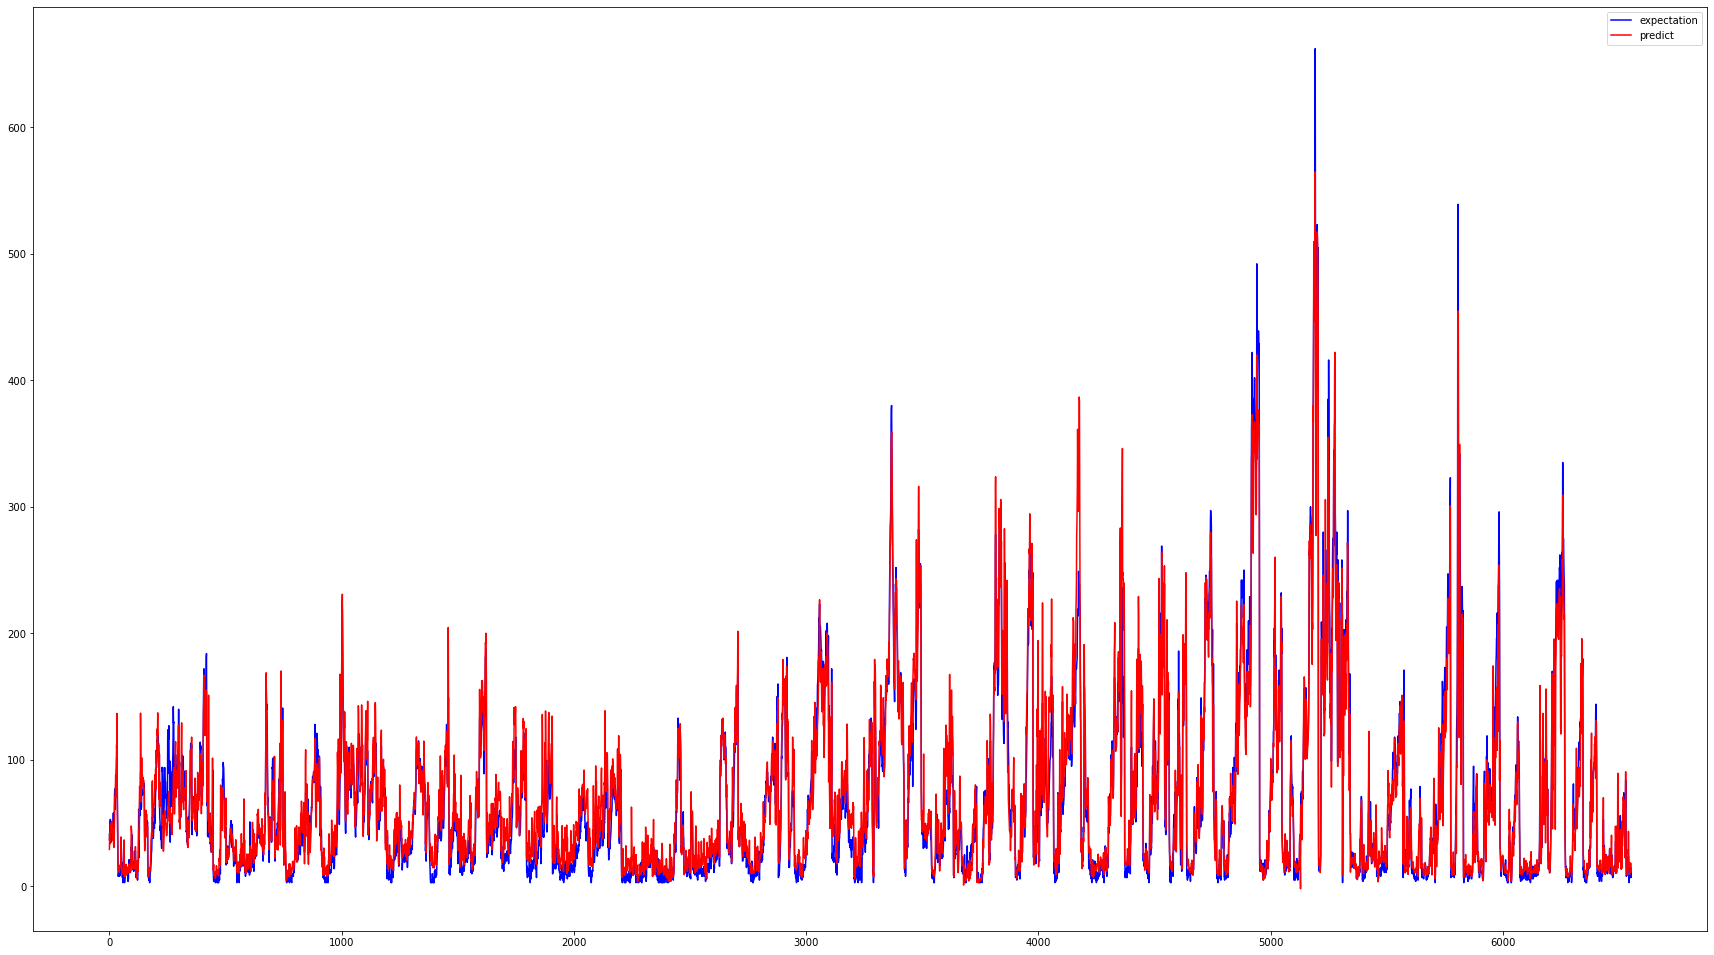

In [22]:
# calculate R-square
for expectation,prediction,station in zip (expectationlist,predictionlist,station_info):
    print(station,":",r2_score(expectation, prediction, multioutput="raw_values"))
plt.figure(figsize=(30, 17))
start=0
end=-1
plt.plot(expectationlist[1][start:end], label="expectation",color="blue")
plt.plot(predictionlist[1][start:end], label="predict", color="red")
plt.legend()
plt.show()

# 2.PM2.5 prediction  by climate factors
* (I). Loading data

In [24]:
from sklearn.utils import shuffle

In [25]:
raw_df=pd.read_csv("./data/PRSA_Data_Aotizhongxin_20130301-20170228.csv")
raw_df=raw_df[(raw_df["month"]==1) | (raw_df["month"]==2) | (raw_df["month"]==3)| (raw_df["month"]==10)| (raw_df["month"]==11)| (raw_df["month"]==12)].reset_index()
raw_df.drop(["No","year","month","hour", "day","wd","station"], axis=1, inplace=True)
raw_df["RH"]=RHcovert(raw_df["TEMP"],raw_df["DEWP"])
raw_df.drop(["PM10","SO2","NO2", "CO","O3","TEMP","DEWP"], axis=1, inplace=True)
raw_df.reset_index()
max_value=np.max(raw_df["PM2.5"])
min_value=np.min(raw_df["PM2.5"])

* (II). Normalization,splitting,shuffling and dropping blank

In [26]:
look_back_step = 24
predict_forward = 1
raw_df=series_to_supervised(
        standardization(raw_df), look_back_step, predict_forward).astype('float32')

In [27]:
raw_df.drop(["PM2.5(t-13)","PM2.5(t-14)","PM2.5(t-15)","PM2.5(t-16)","PM2.5(t-17)","PM2.5(t-18)","PM2.5(t-19)","PM2.5(t-20)","PM2.5(t-21)","PM2.5(t-22)","PM2.5(t-23)","PM2.5(t-24)"],axis=1,inplace=True)
raw_df.drop(["PM2.5(t-12)","PM2.5(t-11)","PM2.5(t-10)","PM2.5(t-9)","PM2.5(t-8)","PM2.5(t-7)","PM2.5(t-6)","PM2.5(t-5)","PM2.5(t-4)","PM2.5(t-3)","PM2.5(t-2)","PM2.5(t-1)"],axis=1,inplace=True)
raw_df.drop(["PRES(t)","RAIN(t)","WSPM(t)","RH(t)"],axis=1,inplace=True)
raw_df=raw_df.dropna().reset_index()

In [28]:
raw_df= shuffle(raw_df)
raw_df.drop(["index(t-13)","index(t-14)","index(t-15)","index(t-16)","index(t-17)","index(t-18)","index(t-19)","index(t-20)","index(t-21)","index(t-22)","index(t-23)","index(t-24)"],axis=1,inplace=True)
raw_df.drop(["index(t)","index","index(t-12)","index(t-11)","index(t-10)","index(t-9)","index(t-8)","index(t-7)","index(t-6)","index(t-5)","index(t-4)","index(t-3)","index(t-2)","index(t-1)"],axis=1,inplace=True)
# raw_df.drop(["index"],axis=1,inplace=True)
raw_df

,PRES(t-24),RAIN(t-24),WSPM(t-24),RH(t-24),PRES(t-23),RAIN(t-23),WSPM(t-23),RH(t-23),PRES(t-22),RAIN(t-22),...,RH(t-3),PRES(t-2),RAIN(t-2),WSPM(t-2),RH(t-2),PRES(t-1),RAIN(t-1),WSPM(t-1),RH(t-1),PM2.5(t)
13834,0.560,0.0,0.089286,0.414274,0.560,0.0,0.125000,0.391962,0.560,0.000000,...,0.345131,0.460,0.000000,0.062500,0.376179,0.460,0.0,0.098214,0.424576,0.017877
11111,0.356,0.0,0.053571,0.648935,0.364,0.0,0.098214,0.710410,0.374,0.000000,...,0.521067,0.438,0.000000,0.125000,0.585259,0.452,0.0,0.133929,0.572609,0.453631
6323,0.360,0.0,0.080357,0.202790,0.320,0.0,0.089286,0.255509,0.420,0.000000,...,0.128270,0.440,0.000000,0.473214,0.105872,0.500,0.0,0.437500,0.106213,0.010056
1776,0.424,0.0,0.053571,0.875317,0.426,0.0,0.053571,0.881993,0.422,0.000000,...,0.456287,0.340,0.000000,0.089286,0.488468,0.336,0.0,0.062500,0.583857,0.174302
8501,0.684,0.0,0.107143,0.351566,0.676,0.0,0.125000,0.320205,0.658,0.000000,...,0.851580,0.460,0.000000,0.169643,0.839282,0.454,0.0,0.178571,0.827427,0.042458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8388,0.416,0.0,0.107143,0.416645,0.420,0.0,0.160714,0.564706,0.430,0.000000,...,0.885111,0.574,0.000000,0.062500,0.859935,0.576,0.0,0.089286,0.841434,0.041341
5302,0.502,0.0,0.071429,0.458866,0.498,0.0,0.116071,0.434965,0.498,0.000000,...,0.849968,0.512,0.008547,0.080357,0.742403,0.492,0.0,0.098214,0.671453,0.175419
6756,0.560,0.0,0.133929,0.689663,0.580,0.0,0.071429,0.784832,0.620,0.017094,...,0.584634,0.520,0.000000,0.241071,0.627159,0.540,0.0,0.178571,0.701016,0.182123
2954,0.516,0.0,0.107143,0.762760,0.532,0.0,0.107143,0.828029,0.550,0.000000,...,0.821262,0.578,0.000000,0.267857,0.788896,0.582,0.0,0.250000,0.788896,0.108380


In [29]:
total=raw_df.shape[0]    
split_point = [total * 60 // 100, total * 80 // 100]
train_data = raw_df[:split_point[0]].values
valid_data = raw_df[split_point[0]: split_point[1]].values
test_data = raw_df[split_point[1]: ].values
train_x_temp, train_y_temp = transform(train_data[:, : -1]), train_data[:, -1]
valid_x_temp, valid_y_temp = transform(valid_data[:, : -1]), valid_data[:, -1]
test_x_temp, test_y_temp = transform(test_data[:, : -1]), test_data[:, -1]


In [30]:
train_x_temp.shape,test_x_temp.shape

((8868, 1, 96), (2957, 1, 96))

* (III). Building model
* * (1). Setting layers and fitting model

In [31]:
model3 = keras.Sequential()
model3.add(tf.keras.layers.LSTM(128, input_shape=(train_x_temp.shape[1], train_x_temp.shape[2]),activation="tanh"))
model3.add(tf.keras.layers.Dense(units=256,activation="sigmoid"))
model3.add(tf.keras.layers.Dense(units=256,activation="tanh"))
model3.add(tf.keras.layers.Dense(units=512,activation="relu"))
model3.add(tf.keras.layers.Dense(units=512,activation="tanh"))
model3.add(tf.keras.layers.Dense(units=1024,activation="tanh"))
model3.add(tf.keras.layers.Dense(units=1024,activation="relu"))
model3.add(keras.layers.Dense(units=1))
model3.compile(loss="mae", optimizer="Adamax")

In [32]:
history3=model3.fit(train_x_temp,
          train_y_temp,
          validation_data=(valid_x_temp, valid_y_temp),
          epochs=5000,
          batch_size=2048,
          verbose=1,
          shuffle=True)

Train on 8868 samples, validate on 2956 samples
Epoch 1/5000
8868/8868 [==============================] - 2s 256us/sample - loss: 1.7695 - val_loss: 0.0792
Epoch 2/5000
8868/8868 [==============================] - 0s 4us/sample - loss: 0.3068 - val_loss: 0.7914
Epoch 3/5000
8868/8868 [==============================] - 0s 4us/sample - loss: 0.5699 - val_loss: 0.1751
Epoch 4/5000
8868/8868 [==============================] - 0s 4us/sample - loss: 0.1953 - val_loss: 0.1696
Epoch 5/5000
8868/8868 [==============================] - 0s 4us/sample - loss: 0.1312 - val_loss: 0.0980
Epoch 6/5000
8868/8868 [==============================] - 0s 4us/sample - loss: 0.0919 - val_loss: 0.0888
Epoch 7/5000
8868/8868 [==============================] - 0s 4us/sample - loss: 0.0878 - val_loss: 0.0800
Epoch 8/5000
8868/8868 [==============================] - 0s 4us/sample - loss: 0.0848 - val_loss: 0.0799
Epoch 9/5000
8868/8868 [==============================] - 0s 4us/sample - loss: 0.0837 - val_loss: 0.0

* (III). Building model
* * (2) Visualization for training process

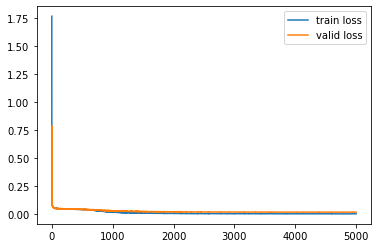

In [37]:
plt.plot(history3.history["loss"], label="train loss")
plt.plot(history3.history["val_loss"], label="valid loss")
plt.legend()
plt.show()

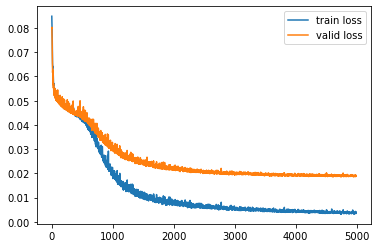

In [38]:
# Remove the first 7 points for better visualization
plt.plot(history3.history["loss"][7:], label="train loss")
plt.plot(history3.history["val_loss"][7:], label="valid loss")
plt.legend()
plt.show()

* (IV). Results of this model

In [33]:
prediction = model3.predict(test_x_temp)
prediction = prediction[:, 0] * (max_value - min_value) + min_value
expectation = (test_y_temp* (max_value - min_value) + min_value)
len(expectation)

2957

[0.91040441]


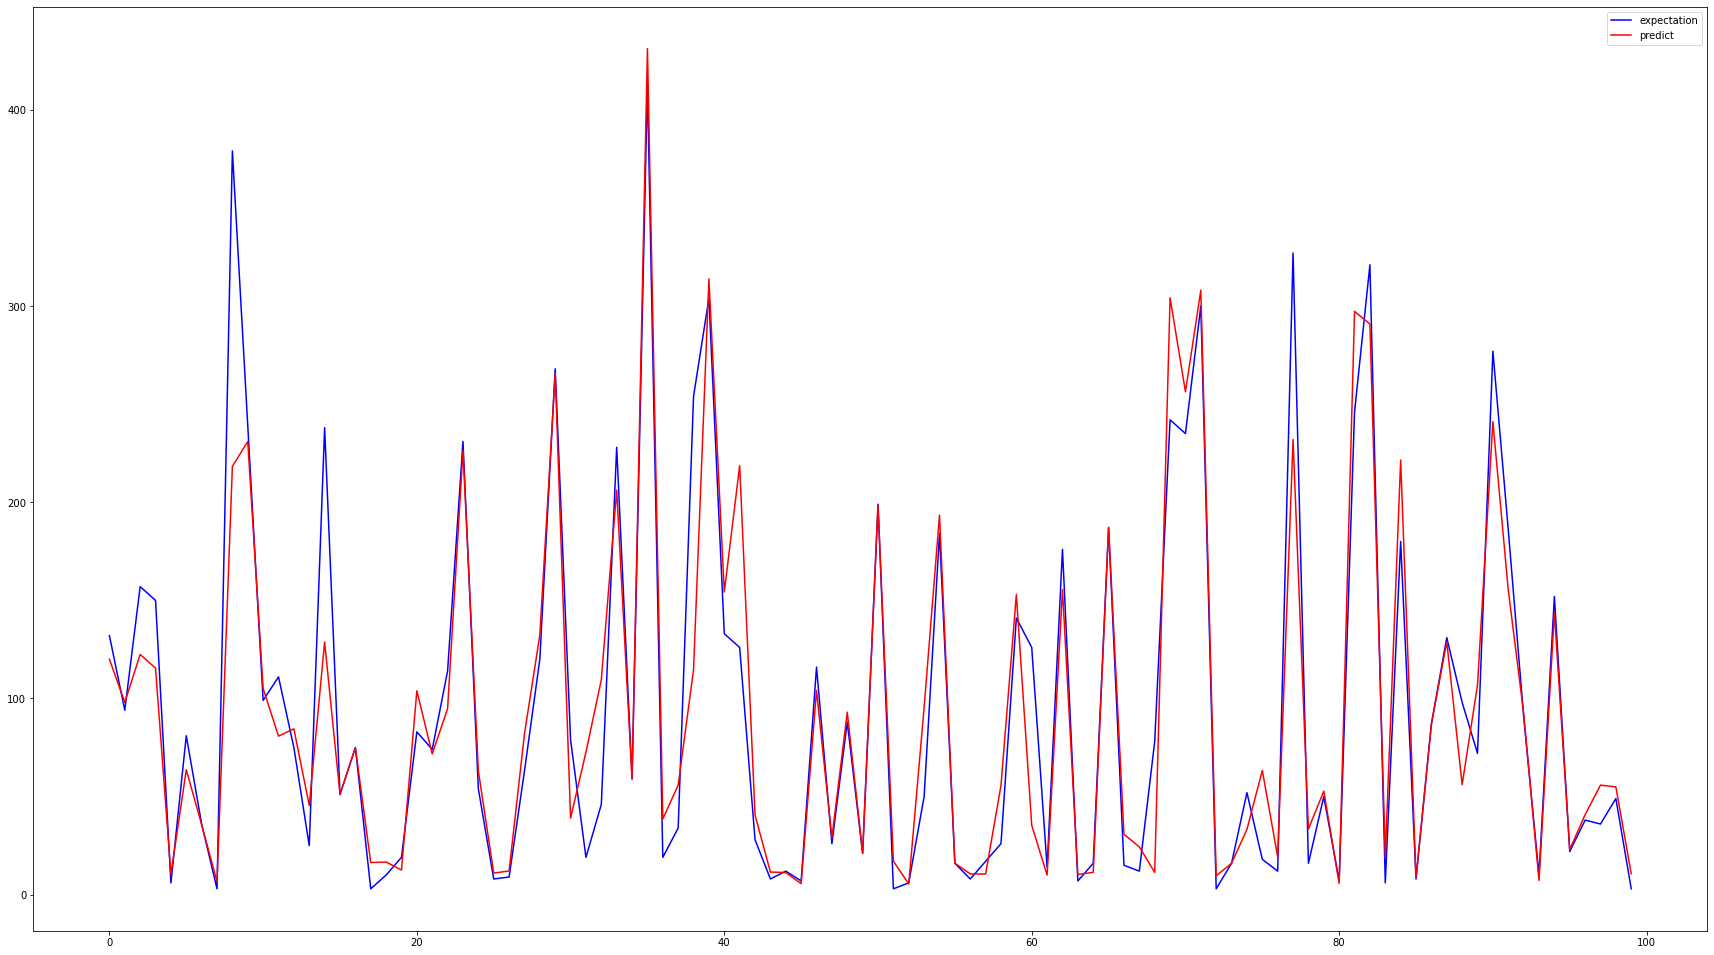

In [34]:
# first 100 points of prediction and expectation
print(r2_score(expectation, prediction, multioutput="raw_values"))
plt.figure(figsize=(30, 17))
start=0
end=100
plt.plot(expectation[start:end], label="expectation",color="blue")
plt.plot(prediction[start:end], label="predict", color="red")
plt.legend()
plt.show()

In [39]:
model3.save("./model/RHANDWSPM/")

INFO:tensorflow:Assets written to: ./model/RHANDWSPM/assets


# add some visualization

In [54]:
# this cell change the location for display, the origin location is in the end of the file
(
    Bar3D(init_opts=opts.InitOpts(width="800px", height="500px"))
    .add(
        series_name="",
        data=data,
        xaxis3d_opts=opts.Axis3DOpts(type_="category", data=[i for i in range(int(len(data)/2))]),
        yaxis3d_opts=opts.Axis3DOpts(type_="category", data=["expectation","prediction"]),
        zaxis3d_opts=opts.Axis3DOpts(type_="value"),
    )
    .set_global_opts(
        visualmap_opts=opts.VisualMapOpts(
            max_=600,
            range_color=[
                "#313695",
                "#4575b4",
                "#74add1",
                "#abd9e9",
                "#e0f3f8",
                "#ffffbf",
                "#fee090",
                "#fdae61",
                "#f46d43",
                "#d73027",
                "#a50026",
            ],
        )
    )
    .render_notebook()
)

In [33]:
from tensorflow import random
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
import tensorflow as tf
import math
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# set random seed
np.random.seed(10086)
random.set_seed(10010)
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

In [34]:
def RHcovert(templist,dewlist):
    rh=[]
    for temp,dew in zip(templist,dewlist):
        rh.append(math.exp(17.27*dew/(237.7+dew)-17.27*temp/(237.7+temp)))
    return rh
# label to id,not used
def label_fit_transform(data_frame, col_name):

    data_frame[col_name] = preprocessing.LabelEncoder().fit_transform(data_frame[col_name])
    return data_frame
# standardization, make data form min-max to 0-1
def standardization(data_frame):
    buffer = data_frame.copy()
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    standard_values = min_max_scaler.fit_transform(buffer)
    for i, col_name in enumerate(buffer.columns):
        buffer[col_name] = standard_values[:, i]

    return buffer
# This step is used for lookback
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    from pandas import DataFrame, concat

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.coumns[j], i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
def transform(values):
    return values.reshape(values.shape[0], 1, values.shape[1])

In [35]:
model=tf.keras.models.load_model('./model/RHANDWSPM')

In [36]:
raw_df=pd.read_csv("./data/PRSA_Data_Aotizhongxin_20130301-20170228.csv")
raw_df=raw_df[(raw_df["month"]==1) | (raw_df["month"]==2) | (raw_df["month"]==3)| (raw_df["month"]==10)| (raw_df["month"]==11)| (raw_df["month"]==12)].reset_index()
raw_df.drop(["No","year","month","hour", "day","wd","station"], axis=1, inplace=True)
raw_df["RH"]=RHcovert(raw_df["TEMP"],raw_df["DEWP"])
raw_df.drop(["PM10","SO2","NO2", "CO","O3","TEMP","DEWP"], axis=1, inplace=True)
raw_df.reset_index()
max_value=np.max(raw_df["PM2.5"])
min_value=np.min(raw_df["PM2.5"])

In [37]:
look_back_step = 24
predict_forward = 1
raw_df=series_to_supervised(
        standardization(raw_df), look_back_step, predict_forward).astype('float32')

In [38]:
raw_df.drop(["PM2.5(t-13)","PM2.5(t-14)","PM2.5(t-15)","PM2.5(t-16)","PM2.5(t-17)","PM2.5(t-18)","PM2.5(t-19)","PM2.5(t-20)","PM2.5(t-21)","PM2.5(t-22)","PM2.5(t-23)","PM2.5(t-24)"],axis=1,inplace=True)
raw_df.drop(["PM2.5(t-12)","PM2.5(t-11)","PM2.5(t-10)","PM2.5(t-9)","PM2.5(t-8)","PM2.5(t-7)","PM2.5(t-6)","PM2.5(t-5)","PM2.5(t-4)","PM2.5(t-3)","PM2.5(t-2)","PM2.5(t-1)"],axis=1,inplace=True)
raw_df.drop(["PRES(t)","RAIN(t)","WSPM(t)","RH(t)"],axis=1,inplace=True)
raw_df=raw_df.dropna().reset_index()

In [39]:
raw_df= shuffle(raw_df)
raw_df.drop(["index(t-13)","index(t-14)","index(t-15)","index(t-16)","index(t-17)","index(t-18)","index(t-19)","index(t-20)","index(t-21)","index(t-22)","index(t-23)","index(t-24)"],axis=1,inplace=True)
raw_df.drop(["index(t)","index","index(t-12)","index(t-11)","index(t-10)","index(t-9)","index(t-8)","index(t-7)","index(t-6)","index(t-5)","index(t-4)","index(t-3)","index(t-2)","index(t-1)"],axis=1,inplace=True)
# raw_df.drop(["index"],axis=1,inplace=True)
raw_df

,PRES(t-24),RAIN(t-24),WSPM(t-24),RH(t-24),PRES(t-23),RAIN(t-23),WSPM(t-23),RH(t-23),PRES(t-22),RAIN(t-22),...,RH(t-3),PRES(t-2),RAIN(t-2),WSPM(t-2),RH(t-2),PRES(t-1),RAIN(t-1),WSPM(t-1),RH(t-1),PM2.5(t)
13834,0.560,0.0,0.089286,0.414274,0.560,0.0,0.125000,0.391962,0.560,0.000000,...,0.345131,0.460,0.000000,0.062500,0.376179,0.460,0.0,0.098214,0.424576,0.017877
11111,0.356,0.0,0.053571,0.648935,0.364,0.0,0.098214,0.710410,0.374,0.000000,...,0.521067,0.438,0.000000,0.125000,0.585259,0.452,0.0,0.133929,0.572609,0.453631
6323,0.360,0.0,0.080357,0.202790,0.320,0.0,0.089286,0.255509,0.420,0.000000,...,0.128270,0.440,0.000000,0.473214,0.105872,0.500,0.0,0.437500,0.106213,0.010056
1776,0.424,0.0,0.053571,0.875317,0.426,0.0,0.053571,0.881993,0.422,0.000000,...,0.456287,0.340,0.000000,0.089286,0.488468,0.336,0.0,0.062500,0.583857,0.174302
8501,0.684,0.0,0.107143,0.351566,0.676,0.0,0.125000,0.320205,0.658,0.000000,...,0.851580,0.460,0.000000,0.169643,0.839282,0.454,0.0,0.178571,0.827427,0.042458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8388,0.416,0.0,0.107143,0.416645,0.420,0.0,0.160714,0.564706,0.430,0.000000,...,0.885111,0.574,0.000000,0.062500,0.859935,0.576,0.0,0.089286,0.841434,0.041341
5302,0.502,0.0,0.071429,0.458866,0.498,0.0,0.116071,0.434965,0.498,0.000000,...,0.849968,0.512,0.008547,0.080357,0.742403,0.492,0.0,0.098214,0.671453,0.175419
6756,0.560,0.0,0.133929,0.689663,0.580,0.0,0.071429,0.784832,0.620,0.017094,...,0.584634,0.520,0.000000,0.241071,0.627159,0.540,0.0,0.178571,0.701016,0.182123
2954,0.516,0.0,0.107143,0.762760,0.532,0.0,0.107143,0.828029,0.550,0.000000,...,0.821262,0.578,0.000000,0.267857,0.788896,0.582,0.0,0.250000,0.788896,0.108380


In [40]:
total=raw_df.shape[0]    
split_point = [total * 60 // 100, total * 80 // 100]
train_data = raw_df[:split_point[0]].values
valid_data = raw_df[split_point[0]: split_point[1]].values
test_data = raw_df[split_point[1]: ].values
train_x_temp, train_y_temp = transform(train_data[:, : -1]), train_data[:, -1]
valid_x_temp, valid_y_temp = transform(valid_data[:, : -1]), valid_data[:, -1]
test_x_temp, test_y_temp = transform(test_data[:, : -1]), test_data[:, -1]


In [41]:
prediction = model.predict(test_x_temp)
prediction = prediction[:, 0] * (max_value - min_value) + min_value
expectation = (test_y_temp* (max_value - min_value) + min_value)
len(expectation)

2957

In [42]:
from pyecharts.charts import Bar3D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.faker import Faker

In [43]:
data=expectation+prediction
group=["expectation","prediction"]

In [44]:
def transfordata(index,data):
    bar=[]
    for i in range(len(data)):
        a=[]
        a.append(index)
        a.append(i)
        a.append(int(data[i]))
        bar.append(a)
    return bar

In [51]:
expect=transfordata(0,expectation)
predict=transfordata(1,prediction)
data_bar_t=expect[0:1000]+predict[0:1000]
type(data_bar_t[0][0])

int

In [52]:
data = [[d[1], d[0], d[2]] for d in data_bar_t]